In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import perf_counter
np.random.seed(0)

This notebook solves the k means clustering problem using a mixture of guassians and the EM algorithm, this also gives a simple example of a latent variable model. 

To begin we assume we have a gaussian mixture distribution on our data which is given by 
$$p(x) = \sum_{k=1}^K \pi_k N(x|\mu_k,\Sigma_k)$$
where $k$ is the number of clusters we expect to have, and $pi_k$ are the percentages of data belonging to each cluster. We introduce the latent variable $z$ which is $K$ dimensional and tracks which cluster a point belongs to i.e. $z_k \in \{0,1\}$ and $\sum_{k} z_k = 1$. We get the joint distribution $p(x,z)$ by instead computing the marginal and conditionals $p(z),p(x|z)$ which are easy and given by
$$p(z) = \prod_{k=1}^K \pi_k^{z_k}$$
$$p(x|z) = \prod_{k=1}^K N(x|\mu_k,\Sigma_k)^{z_k}$$
from this we can rewrite $p(x)$ by marginalizng over $p(z)p(x|z)$
$$p(x) = \sum_{z} p(z)p(x|z)  =  \sum_{k=1}^K \pi_k N(x|\mu_k,\Sigma_k)$$$$p(x) = \sum_{k=1}^K \pi_k N(x|\mu_k,\Sigma_k)$$$$p(x) = \sum_{k=1}^K \pi_k N(x|\mu_k,\Sigma_k)$$$$p(x) = \sum_{k=1}^K \pi_k N(x|\mu_k,\Sigma_k)$$

First we set up some data according to this distribution

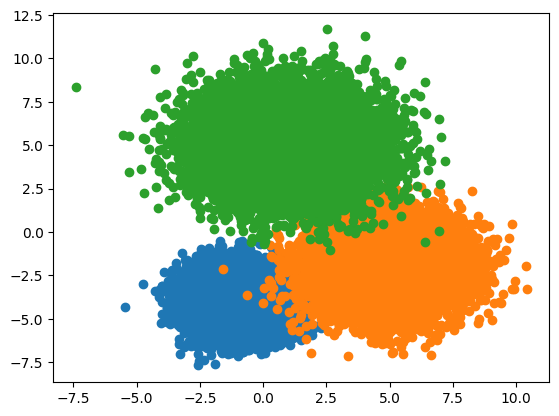

In [9]:
N,K,D = 30000,3,2

mus = np.array([[-1,-4],[5,-2],[1,5]])
covs = np.array([np.eye(2), np.eye(2)*2, np.eye(2)*3])
pis = [0.33333,0.33333,0.33333]

mu1,mu2,mu3 = mus
cov1,cov2,cov3 = covs

g1 = np.random.multivariate_normal(mu1,cov1, size = N//K)
g2 = np.random.multivariate_normal(mu2,cov2, size = N//K)
g3 = np.random.multivariate_normal(mu3,cov3, size = N//K)

xs = np.vstack([g1,g2,g3])

plt.scatter(g1[:,0],g1[:,1])
plt.scatter(g2[:,0],g2[:,1])
plt.scatter(g3[:,0],g3[:,1])

In [10]:
# helper code to compute the normal probablities
def eval_normal_slow(x,u,s):
        k = x.shape[0]
        invs = np.linalg.inv(s)
        dets = np.linalg.det(s)
        y = -0.5*(x-u).T@invs@(x-u)
        return np.exp(y)/(np.sqrt((2*np.pi)**k * dets))

def eval_normal(x,u,s):
        # x : N x D
        # u : K X D
        # s : K X D X D
        N,K,D = x.shape[0],u.shape[0],u.shape[1]
        sinv = np.linalg.inv(s)
        dets = np.linalg.det(s)
        xs = x.reshape(N,1,D)-u.reshape(1,K,D)
        xs = xs.reshape(N,K,D,1)
        # need this for multiplying later
        subs = xs.copy()
        xs = np.transpose(xs,(0,1,3,2))@sinv
        xs = xs@subs
        slow = np.zeros((N,K,1,1))
        xs = xs.squeeze()
        return np.exp(-0.5*xs)/np.sqrt((2*np.pi)**D * dets)

Like everything so far we are going to use MLE so the log likelihood, $N$ is the size of the data $K$ is the number of clusters
$$ln(p(X|\pi,\mu,\Sigma) = \sum_{n=1}^N \ln \sum_{k = 1}^k \pi_kN(x_n|\mu_k,\sigma_k)$$
Next we define the quantity
$$\gamma(z_nk) = p(z_k = 1|x_n) = \frac{\pi_kN(x_n|u_k,\Sigma_k)}{\sum_{j=1}^K \pi_jN(x_n|u_j,\Sigma_j)}$$
this quantity can be interepreted as how much belonging to the $k$th cluster makes sense for the observation $x_n$

Taking gradients wrt the parameters in the log likelihood we find that 
$$\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})x_n$$
$$\Sigma_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})(x_n-\mu_k)(x_n-\mu_k)^T$$
$$\pi_k = \frac{N_k}{N}$$
where we have defined $N_k = \sum_{n=1}^N \gamma(z_{nk})$. Note that $\mu,\Sigma$ are given by essentially weighted sums which becoming bigger the more we are placing each point in its correct cluster. Also note that $\pi$ must be found with lagrange multipliers since we have the constrain $\sum \pi_k = 1$. We also have hidden in the notation the fact that this is not a closed form! $\pi,\mu,\Sigma$ all depend on the quantities $\gamma(z_{nk})$. This is what leads to the EM algorithm, at each step we first compute $\gamma(z_{nk})$, then use $\pi,\mu,\Sigma$. Essentially we take turns maximizing the latent and explicit variables compute the log likelihood, and look for it or the variables to converge to a value.


In [11]:
def log_likelihood(xs,mus,sigmas,pis):
    # x: N x D
    # mus: K x D
    # sigmas K x D x D
    # pis K x 1
    return np.sum(np.log(np.sum(eval_normal(xs,mus,sigmas)*pis,axis=1)))

#compute ll of the data with exact params to see what it should be
log_likelihood(xs,mus,covs,pis)

-135223.87808404758

In [12]:
def em_algo(xs,mus,sigmas,pis,tol=1e-6,max_iters=100):
    N,D,K = xs.shape[0],xs.shape[1],mus.shape[0]
    def get_es(m,s,p):
        x = p*eval_normal(xs,m,s)
        d = x.sum(axis=1).reshape(N,1)
        return x/d
        
    def maximize_step(es):
        #N_k sum kth column
        Nk = np.sum(es,axis=0).reshape(K,1)
        pis_new = Nk/N
        # N X K X 1
        # N X 1 X D
        # -> K X D
        mus_new = np.sum(es.reshape(N,K,1)*xs.reshape(N,1,D),axis=0)
        mus_new /= Nk

        # N x 1 X D
        # 1 X K X D
        # -> N X K X D
        xs_reshape = xs.reshape(1,N,D)
        mus_reshape = mus_new.reshape(K,1,D)
        A = xs_reshape - mus_reshape
        
        A = A.reshape(K,N,D,1)
        # K x N X D X 1
        # K X N X 1 X D
        # -> K X N X D X D
        B = A@np.transpose(A,(0,1,3,2))

        # K X N X D X D
        # K X N X 1 X 1
        #  -> K X N X D X D
        es_reshape = es.reshape(N,K,1,1)
        es_reshape = np.transpose(es_reshape,(1,0,2,3))
        sigmas_new = (es_reshape*B).sum(axis=1)
        #  -> K X D X D
        Nk = Nk.reshape(K,1,1)
        sigmas_new /= Nk

        return mus_new,sigmas_new,pis_new.reshape(1,K)
    
    converged = False
    iter_count = 0
    
    old_m,old_s,old_p = mus,sigmas,pis
    old_ll = log_likelihood(xs,mus,sigmas,pis)
    while not converged and iter_count < max_iters:
        t0_es = perf_counter()
        es = get_es(old_m,old_s,old_p)
        t1_es = perf_counter()

        t0_max = perf_counter()
        m,s,p = maximize_step(es)
        t1_max = perf_counter()

        t0_ll = perf_counter()
        ll = log_likelihood(xs,m,s,p)
        t1_ll = perf_counter()
        # print(f"Total loop time: {t0_ll-t0_es}")
        # print(f"es loop time: {t1_es-t0_es}")
        # print(f"max loop time: {t1_max-t0_max}")
        # print(f"ll loop time: {t1_ll-t0_ll}")
        if abs(old_ll-ll) < tol:
            converged = True
        if iter_count % 10 == 0:
            #print(f"diff: {abs(old_ll - ll)}")
            print(f"Step {iter_count+1}, ll: {ll}")
        old_ll = ll
        old_m, old_s, old_p = m,s,p
        iter_count += 1
        
    return old_m,old_s,old_p  
    

def guess_params(xs,k,d):
    N = xs.shape[0]
    Nk = (N//k)
    idxs = np.random.choice(N,size=(k,Nk))
    guess_mu = np.mean(xs[idxs],axis=1)
    guess_cov = np.array([np.eye(d)]*k)
    guess_pi = np.array([Nk/N]*k)
    return guess_mu, guess_cov, guess_pi


guess_mu, guess_cov, guess_pi = guess_params(xs,K,D)
approx_mus,approx_sigmas,approx_pis = em_algo(xs,guess_mu,guess_cov,guess_pi)

Step 1, ll: -159104.82643483081
Step 11, ll: -144794.4700183128
Step 21, ll: -141896.59920115414
Step 31, ll: -135905.44846198888
Step 41, ll: -135219.33338608808


This is the slow version of the vectorized code, can be ignored (270x slower!)

In [13]:
def log_likelihood_slow(xs,mus,sigmas,pis):
    # x: N x D
    # mus: K x D
    # sigmas K x D x D
    # pis K x 1
    N,K = xs.shape[0],mus.shape[0]
    l = 0.0
    for n in range(N):
        c = 0.0
        for k in range(K):
            c += pis[k]*eval_normal_slow(xs[n],mus[k],sigmas[k])
        l += np.log(c)
    return l

In [14]:
def em_algo_slow(xs,mus,sigmas,pis,tol=1e-3,max_iters=50):
    N,D,K = xs.shape[0],xs.shape[1],mus.shape[0]
    def get_es_slow(m,s,p):
        es = np.zeros((N,K))
        for n in range(N):
            denom = np.sum([p[j]*eval_normal_slow(xs[n],m[j],s[j]) for j in range(K)])
            for k in range(K): 
                num = pis[k]*eval_normal_slow(xs[n],m[k],s[k])
                es[n,k] = num/denom
        return es
    def maximize_step_slow(es):
        Nk = np.sum(es,axis=0).reshape(K,1)
        pis2 = Nk/N
        mus_slow = np.zeros((K,D))
        for k in range(K):
            mus_slow[k] = np.sum([es[n,k]*xs[n] for n in range(N)],axis=0)
        mus_slow /= Nk

        sigmas_slow = np.zeros((K,D,D))
        for k in range(K):
            c = np.zeros((D,D))
            for n in range(N):
                z = (xs[n]-mus[k]).reshape(D,1)
                #sigmas_slow[k,n] = z@z.T
                c += es[n,k]*(z@z.T)
            c /= Nk[k]
            sigmas_slow[k] = c
        return mus_slow,sigmas_slow,pis2
    
    converged = False
    iter_count = 0
    
    old_m,old_s,old_p = mus,sigmas,pis
    old_ll = log_likelihood_slow(xs,mus,sigmas,pis)
    while not converged and iter_count < max_iters:
        
        t0_es = perf_counter()
        es = get_es_slow(old_m,old_s,old_p)
        t1_es = perf_counter()

        t0_max = perf_counter()
        m,s,p = maximize_step_slow(es)
        t1_max = perf_counter()

        t0_ll = perf_counter()
        ll = log_likelihood_slow(xs,m,s,p)
        t1_ll = perf_counter()
        # print(f"Total loop time: {t0_ll-t0_es}")
        # print(f"es loop time: {t1_es-t0_es}")
        # print(f"max loop time: {t1_max-t0_max}")
        # print(f"ll loop time: {t1_ll-t0_ll}")
        if abs(old_ll-ll) < tol:
            converged = True
        if iter_count % 10 == 0:
            #print(f"diff: {abs(old_ll - ll)}")
            print(f"Step {iter_count+1}, ll: {ll}")
        old_ll = ll
        old_m, old_s, old_p = m,s,p
        iter_count += 1
        
    return old_m,old_s,old_p

In [15]:
def cov_to_ellipse(cov):
    #https://cookierobotics.com/007/
    a,b,c = cov[0][0],cov[0][1],cov[1][1]
    l1 = (a+c)/2 + np.sqrt(((a-c)**2)/4 + b**2)
    l2 = (a+c)/2 - np.sqrt(((a-c)**2)/4 + b**2)
    theta = 0
    if b == 0 and a >= c:
        theta = 0
    if b == 0 and a < c:
        theta = np.pi/2
    else:
        theta = np.arctan2(l1-a,b)
    return np.sqrt(abs(l1)),np.sqrt(abs(l2)),theta
    
def covs_to_ellipse(covs,mus):
    t = np.linspace(0,2*np.pi)
    for i,c in enumerate(covs):
        l1,l2,theta = cov_to_ellipse(c)
        xs = l1*np.cos(theta)*np.cos(t) - l2*np.sin(theta)*np.sin(t)
        ys = l1*np.sin(theta)*np.cos(t) - l2*np.cos(theta)*np.sin(t)
        xs += mus[i][0]
        ys += mus[i][1]
        plt.plot(xs,ys,label=f"$\Sigma_{i}$")
        

def plot_res(xs,mus,sigmas):
    plt.scatter(xs[:,0],xs[:,1],color="r")
    for k in range(len(mus)):
        plt.scatter(mus[k][0],mus[k][1],label=f"$\mu_{k}$")
    covs_to_ellipse(sigmas,mus)
    plt.legend()




Exact mus:
[[-1 -4]
 [ 5 -2]
 [ 1  5]]
Approx mus:
[[ 0.99226355  5.00889627]
 [ 5.00109781 -1.99955928]
 [-1.00781236 -3.99525764]]
Exact sigmas:
[[[1. 0.]
  [0. 1.]]

 [[2. 0.]
  [0. 2.]]

 [[3. 0.]
  [0. 3.]]]
Approx sigmas:
[[[3.0039591  0.00516201]
  [0.00516201 2.95378465]]

 [[1.98393028 0.03145394]
  [0.03145394 2.01128601]]

 [[0.99242146 0.00728027]
  [0.00728027 0.97713108]]]
Exact pis:
[0.33333, 0.33333, 0.33333]
Approx pis:
[[0.33309398 0.33301569 0.33389033]]


Text(0.5, 1.0, 'Exact')

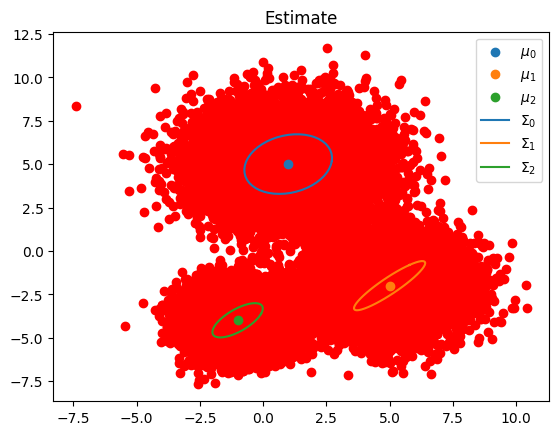

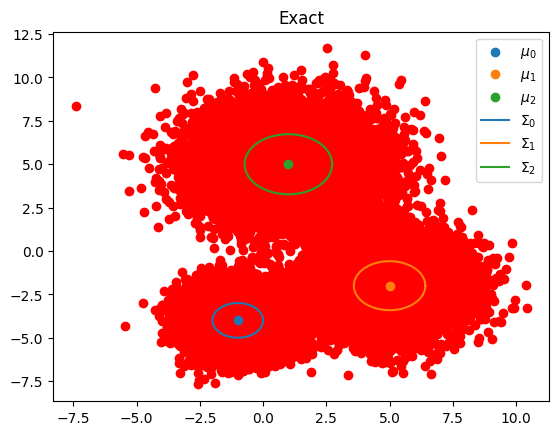

In [16]:
print("Exact mus:")
print(mus)
print("Approx mus:")
print(approx_mus)

print("Exact sigmas:")
print(covs)
print("Approx sigmas:")
print(approx_sigmas)

print("Exact pis:")
print(pis)
print("Approx pis:")
print(approx_pis)

plot_res(xs,approx_mus,approx_sigmas)
plt.title("Estimate")
plt.figure()

plot_res(xs,mus,covs)
plt.title("Exact")